# Tabular Q-learning using a linear model 

This example implements tabular Q-learning via a linear model and applies it to simple gridworlds. The implementation was inspired by code snippets published online. If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

In [1]:
import tensorflow as tf

import gym
import gym_gridworlds  # pip install gym-gridworlds

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Choose either of the two environments
env_name = 'CliffWalking-v0'
# env_name = 'FrozenLake-v0'
env = gym.make(env_name)  

env.render()

number_of_actions = env.action_space.n
number_of_states = env.observation_space.n
print("|S| =", number_of_states)
print("|A| =", number_of_actions)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

|S| = 48
|A| = 4


In [25]:
tf.reset_default_graph()

# Define linear model, one coud also use tf.layers.dense
x = tf.placeholder(shape=[None, number_of_states],dtype=tf.float32)  # input state
W = tf.Variable(tf.random_uniform([number_of_states, number_of_actions], 0., 0.01))
y = tf.matmul(x, W) # 4 Q-values for all possible actions

argmax_y = tf.argmax(y, 1) # best action

#  Loss is suared difference between  target and predicted Q values.
target = tf.placeholder(shape=[None, number_of_actions], dtype=tf.float32)
lr = tf.placeholder(dtype=tf.float32)
loss = tf.reduce_sum(tf.square(target - y))
trainer = tf.train.GradientDescentOptimizer(learning_rate = lr)
train_step = trainer.minimize(loss)

<tf.Tensor 'MatMul:0' shape=(?, 4) dtype=float32>

In [4]:
init = tf.global_variables_initializer()

# Set learning parameters
gamma = .99  # gamma
initial_epsilon = epsilon = 0.1  # epsilon for epsilon-greedy selection
number_of_episodes = 2000
max_number_of_steps = 100
eta = 0.1  # (initial) learning rate
T_list = []  # list gathering maximum number of steps for each episode
R_list = []  # list gathering returns (accumulated rewards) for each episode
with tf.Session() as sess:
    sess.run(init)
    for i in tqdm(range(number_of_episodes)):
        s = env.reset()  # reset environment and get first state
        R = 0  # return (accumulated reward)
        for t in range(max_number_of_steps):  # maximum number of steps
            
            # Choose an action greedily (with e chance of random action) from the Q-network
            a, Q = sess.run([argmax_y, y], feed_dict={x:np.eye(1, number_of_states, s)})
            if np.random.rand(1) < epsilon:
                a[0] = env.action_space.sample()
            
            # Observe new state and reward from environment
            s_prime, r, d, _ = env.step(a[0])
            
            
            # Compute Q' by feeding the new state into the network
            Q_prime = sess.run(y, feed_dict={x:np.eye(1, number_of_states, s_prime)})
          
            # Set targets
            # Compute maximum value of Q_prime and set  target value for chosen action
            max_Q_prime = np.max(Q_prime)
            Q_target = Q
            Q_target[0, a[0]] = r + gamma * max_Q_prime
            
            # Update Q networks network weights
            # Train network using target and predicted Q values
            _, weights = sess.run([train_step, W], feed_dict={x:np.eye(1, number_of_states, s), target:Q_target, lr:eta})
            R += r
            s = s_prime
            if d == True:  # episode ended
                # Reduce probability of random actions over time
                epsilon = 1./((i/50) + (1./initial_epsilon))
                break
        T_list.append(t)
        R_list.append(R)

100%|██████████| 2000/2000 [00:31<00:00, 63.97it/s]


In [18]:
{x:np.eye(1, number_of_states, s)}

{<tf.Tensor 'Placeholder:0' shape=(?, 48) dtype=float32>: array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])}

In [17]:
a

array([2])

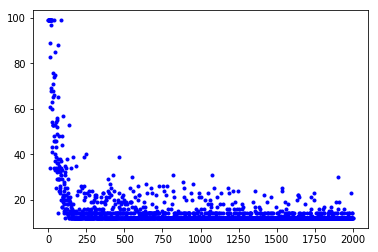

In [5]:
if env_name == 'FrozenLake-v0':
    print("Percent of succesful episodes:", sum(R_list)/number_of_episodes)
plt.plot(R_list, 'g.')
plt.show()
plt.plot(T_list, 'b.')
plt.show()

In [6]:
env.render()

if env_name == 'FrozenLake-v0':
    print("V:\n", np.around(np.max(weights, 1).reshape((4,4)), decimals=1))
    print("actions:\n", np.argmax(weights, 1).reshape((4,4)))
if env_name == 'CliffWalking-v0':
    print("V:\n", np.around(np.max(weights, 1).reshape((4,12))))
    print("actions:\n", np.argmax(weights, 1).reshape((4,12)))

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

V:
 [[-11. -11. -10.  -9.  -9.  -8.  -7.  -6.  -5.  -5.  -4.  -3.]
 [-11. -11. -10.  -9.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.]
 [-11. -10. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
 [-12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
actions:
 [[1 0 1 0 1 1 1 1 2 1 2 2]
 [1 0 2 1 2 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 1 1 0 3 0 1 3 2 0 2 2]]
